In [1]:
############################
## import packages
############################
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn

print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', matplotlib.__version__)
print('sklearn version:', sklearn.__version__)

pandas version: 1.1.0
numpy version: 1.19.1
matplotlib version: 3.3.0
sklearn version: 0.23.2


In [2]:
############################################################################################
# Get MNIST data (70000 X 784):
# 70,000 small images of digits handwritten by HS students and US Census Bureau employees
# 28X28=784 pixels (describing each image) -> pixel intensity  from 0 (white) to 255 (black)
############################################################################################
from sklearn.datasets import fetch_openml

mnist = fetch_openml(name='mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
# let's work with half the data
X, y = X[:35000], y[:35000]
X.shape, y.shape

((35000, 784), (35000,))

In [5]:
# visualize one digit image
some_digit = X[0]
"""
some_digit_image = some_digit.reshape(28,28)    # reshape feature vector to 28X28 array
plt.imshow(some_digit_image, cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()
"""

"\nsome_digit_image = some_digit.reshape(28,28)    # reshape feature vector to 28X28 array\nplt.imshow(some_digit_image, cmap='binary', interpolation='nearest')\nplt.axis('off')\nplt.show()\n"

In [6]:
y[0]        # label of image above

'5'

In [7]:
# transform string label to numerics (most algorithms expect numerical inputs)
y = y.astype(np.int8)
y[0]

5

In [8]:
# train-test split (data comes pre-split)
# training set should be shuffled, to guarantee all cross-validation folds are similar
# (no action needed - MINST's training data is already shuffled)
X_train, y_train, X_test, y_test = X[:30000], y[:30000], X[30000:], y[30000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30000, 784), (30000,), (5000, 784), (5000,))

In [9]:
#################################################
# binary classifier
#################################################
# convert to two classes: '5' and 'not-5'
y_train_5 = (y_train == 5)      # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [10]:
# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
###################################################
# custom cross-validation for more control
###################################################
# StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio
# of each class. At each iteration the code below creates a clone of the classifier, trains that clone on
# the training folds, and makes predictions on the test fold.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X=X_train, y=y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]      # cross-validation on training set only
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct / len(y_pred))

0.9458
0.9634
0.9603


In [13]:
# such abnormally high acuracy is a result of only 10% of images being 5s, so even a dumb classifier
# that always guesses not-5 will have 90% accuracy -> accuracy is not a good evaluation metric for
# skewed datasets (some classes are much more frequent than others)

# same high accuracy with standard 3-fold cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.9458, 0.9634, 0.9603])

In [14]:
#####################################################################
# confusion matrix
#####################################################################
# first get prediciton on each test fold from cross validation above
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs=-1)
y_train_pred.shape

(30000,)

In [15]:
# next look at confusion matrix
# each row represents true class, each column represents predicted class
# -> top row (negative class): TN, FP
# -> btm row (positive class): FN, TP
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

array([[26515,   776],
       [  529,  2180]], dtype=int64)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
# precision -> % positive *prediction* that are correct = TP/(TP + FP) = 2180/(2180 + 776)
print('precision:', precision_score(y_true=y_train_5, y_pred=y_train_pred))
# recall -> % positive *data* that are correctly predicted = TP/(TP + FN) = 2180/(2180 + 529)
print('recall:', recall_score(y_true=y_train_5, y_pred=y_train_pred))
# f1-score = 2 X (precision X recall)/(precision + recall)
# f1-score favors classifiers that have similar precision and recall, not always desirable
print('f1-score:', f1_score(y_true=y_train_5, y_pred=y_train_pred))

precision: 0.7374830852503383
recall: 0.8047249907715024
f1-score: 0.7696381288614299


In [17]:
#############################################################
# precision/recall tradeoff
#############################################################
# Binary classifiers predict positive/negative class by computing a score based on a decision function (of feacture variables)
# -> if the score exceeds a threshold, the instance is assigned to positive class, else negative class.
# Raising/lowering threshold raises/lowers precision (lowers/raises recall)
# To choose threshold, first get all scores for training set from cross_val_predict()
y_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, method='decision_function', n_jobs=-1)
# next compute all possible threasholds using 'precision_recall_curve()':
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

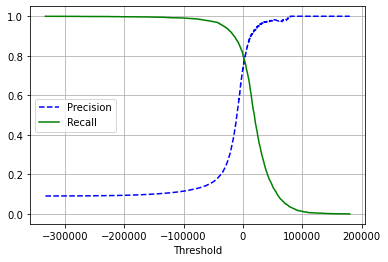

In [18]:
# function to plot precision/recall against threshold values
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

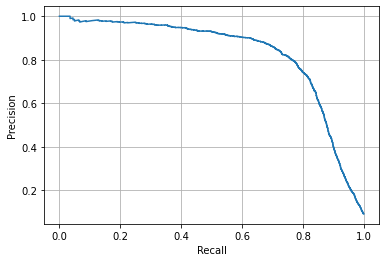

In [19]:
# plot precision against recall
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()
# precision drops sharply against 80% recall
# -> select precision/recall tradeoff before this drop, say ~60% recall

In [20]:
##############################################################
# ROC (Receiver Operating Characteristic) curve
##############################################################
# TPR (true positive rate, or recall) vs FPR (=1-TPR)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true=y_train_5, y_score=y_scores)

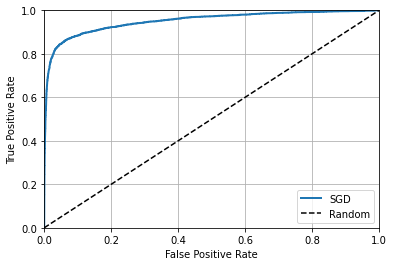

In [21]:
# dotted line shows ROC curve of a purely random classifier
# -> good clssifier stays as far away from this line as possible
# Another tradeoff -> higher recall (TPR) generates more FPR

# function to plot ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label='Random')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()

plot_roc_curve(fpr, tpr, label='SGD')
plt.show()

In [22]:
# ROC AUC (area under curve) -> used to compare classifiers
# -> AUC=1 (perfect classificer), AUC=0.5 (purely random classifier)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9509867800410808

In [23]:
# Use PR (precision/recall) curve when positive class is rare, or when
# false positive is more important than false negative (as in medical dignostics),
# and ROC curve otherwise

In [24]:
# train Random Forest classifier and compare its ROC with SGD classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(estimator = forest_clf,
                                    X = X_train, 
                                    y = y_train_5,
                                    cv = 3,
                                    method = 'predict_proba',
                                    n_jobs = -1)

# to plot ROC curve, we need scores, not probabilities
y_scores_forest = y_probas_forest[:, 1]     # score = proability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

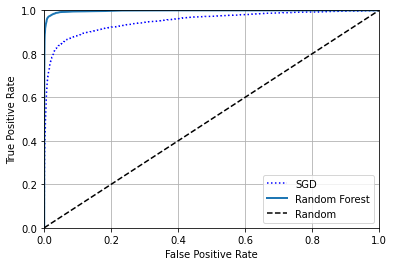

In [25]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [26]:
# ROC AUC, precision, recall for Random Forest
print('ROC AUC:', roc_auc_score(y_train_5, y_scores_forest))

y_preds_forest = cross_val_predict(estimator = forest_clf,
                                   X = X_train, 
                                   y = y_train_5,
                                   cv = 3, 
                                   n_jobs = -1)
print('Precision:', precision_score(y_true=y_train_5, y_pred=y_preds_forest))
print('Recall:', recall_score(y_true=y_train_5, y_pred=y_preds_forest))

ROC AUC: 0.9976909785689067
Precision: 0.9887250650477016
Recall: 0.8416389811738649


In [27]:
#################################################
# multiclass/multinomial classifier
#################################################
# OvA (one-vs-all) or OvO (one-vs-one) method of training multiclass system with strictly binary classifier
# (sklearn automatically chooses OvO or OvA depending on algorithm to train)
# train Support Vector Classifier (strictly binary classifier) for all image classes
# SVMs with nonlinear kernel has complexity of O(n_samples^2 * m_features) -> LinearSVC is being trained below
from sklearn.svm import LinearSVC
svm_clf = LinearSVC()
svm_clf.fit(X=X_train, y=y_train)       # multiclass (y_train, not y_train_5)
svm_clf.predict([some_digit])

array([3], dtype=int8)

In [28]:
some_digit_scores = svm_clf.decision_function(X=[some_digit])
print(some_digit_scores)
print(svm_clf.classes_[np.argmax(some_digit_scores)])

[[-3.8633729  -8.28837624 -2.39600714  0.32017709 -5.99609875  0.05426636
  -5.87921438 -4.76790537 -4.13126479 -2.70484256]]
3


In [29]:
# -> train SGD (multiclass classifier - no OvO/OvA needed)
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)
sgd_clf.fit(X=X_train, y=y_train)
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function(X=[some_digit]))

[5]
[[ -50458.5075631  -136486.63842062  -14135.49961456  -10399.0572803
   -63068.57630296   -3043.28005489  -64103.92249307  -68757.6494235
   -44670.30230201  -27252.81246434]]


In [30]:
# Random Forest (another multiclass classifier)
forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
forest_clf.fit(X=X_train, y=y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))   # probabilities of all 10 classes (probability of class '5' is highest)

[5]
[[0.   0.   0.01 0.1  0.   0.86 0.   0.01 0.   0.02]]


In [31]:
# model evaluation with cross-validation
print('SVC:', cross_val_score(estimator=svm_clf, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1))
print('SGD:', cross_val_score(estimator=sgd_clf, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1))
print('RandomForest:', cross_val_score(estimator=forest_clf, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1))

SVC: [0.87383333 0.86866667 0.84816667 0.83816667 0.862     ]
SGD: [0.88366667 0.864      0.86916667 0.87766667 0.8725    ]
RandomForest: [0.96366667 0.96033333 0.9555     0.95933333 0.95583333]


In [32]:
# 85+% accuracy from SGD on all 5 test folds -> can be improved further by simply scaling inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X=X_train.astype(np.float64))
cross_val_score(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=5, scoring='accuracy', n_jobs=-1)

array([0.908     , 0.90266667, 0.89116667, 0.90283333, 0.90733333])

In [33]:
#####################################################
# error analysis (more reliable than accuracy)
#####################################################
# assume we already have chosen our best model, SGD - now let's improve it
# first, get confusion matrix
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=5, n_jobs=-1)
conf_mtrx = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
conf_mtrx

array([[2806,    0,   15,    3,    4,   30,   18,    2,   83,    0],
       [   1, 3252,   24,   13,    3,   28,    2,    3,   91,    6],
       [  14,   18, 2572,   62,   39,   15,   36,   21,  165,    6],
       [  12,   15,   68, 2651,    2,   96,   12,   26,  153,   38],
       [   9,    7,   25,    6, 2622,    4,   20,    8,  129,   96],
       [  15,   12,   18,   80,   41, 2261,   35,    6,  202,   39],
       [  17,    6,   20,    0,   21,   48, 2801,    5,   57,    0],
       [  10,    2,   31,   15,   27,    3,    3, 2821,   59,  136],
       [   6,   34,   21,   53,    2,   59,   21,    3, 2651,   25],
       [  18,   13,   16,   31,   62,   15,    1,   88,  124, 2635]],
      dtype=int64)

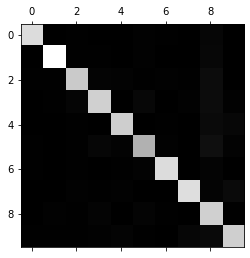

In [34]:
# visualize confusion matrix
plt.matshow(conf_mtrx, cmap=plt.cm.gray)
plt.show()

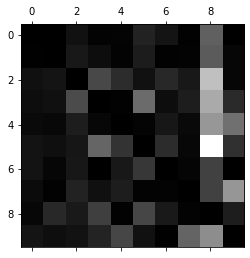

In [35]:
# plot only errors (large correct prediction along diagonal masks off-diagonal errors)
row_sums = conf_mtrx.sum(axis=1, keepdims=True)
norm_conf_mtrx = conf_mtrx / row_sums
np.fill_diagonal(norm_conf_mtrx, 0)         # fill diagonal with 0 to keep only errors
plt.matshow(norm_conf_mtrx, cmap=plt.cm.gray)
plt.show()
# columns 8 and 9 are brighter -> many images misclassified as 8 or 9 (rows are actual classes, columns are predicted classes)
# row 1 is pretty dark -> most 1s are classified correctly

In [36]:
#########################################################################
# multilabel classification -> each row/instance assigned multiple labels
#########################################################################
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [ True,  True],
       [False,  True]])

In [37]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X=X_train, y=y_multilabel)
knn_clf.predict([some_digit])           # correct prediction -> digit '5' is not large and odd

array([[False,  True]])

In [38]:
# model evaluation
knn_pred = cross_val_predict(estimator=knn_clf, X=X_train, y=y_multilabel, cv=3, n_jobs=-1)
print(f1_score(y_multilabel, knn_pred, average="macro"))        # assumes all labels are equally important (not always true)
print(f1_score(y_multilabel, knn_pred, average="weighted"))     # assigns each label a weight equal to its 'support' (number of rows with that label)

0.9699330758452971
0.9717347123179275


In [39]:
#################################################################
# multioutput (multioutput-multiclass) classifier
# ex: identifying animals in a picture, N classes for each animal 
#################################################################
# build model to remove noise from images
# first add noise to MNIST images
noise = np.random.randint(low=0, high=100, size=(X_train.shape[0], 784))
X_train_mod = X_train + noise
noise = np.random.randint(low=0, high=100, size=(X_test.shape[0], 784))
X_test_mod = X_test + noise
y_train_mod = X_train.copy()        # multilabel (784 pixel values for each instance)
y_test_mod = X_test.copy()

In [40]:
"""
# visualize one digit image
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[0].axis('off')
ax[1].imshow(y_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()
"""

"\n# visualize one digit image\nfig, ax = plt.subplots(nrows=1, ncols=2)\nax[0].imshow(X_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[0].axis('off')\nax[1].imshow(y_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[1].axis('off')\nplt.show()\n"

In [41]:
# train model and clean image data
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X=X_train_mod, y=y_train_mod)
clean_digit = knn_clf.predict(X=[X_test_mod[234]]).reshape(28, 28)   # reshape cleaned output to image 

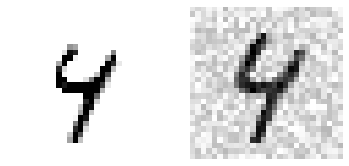

In [42]:
# plot output
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(clean_digit, cmap='binary'); ax[0].axis('off')
ax[1].imshow(X_test_mod[234].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

In [43]:
###########################################################################################
# Exercise #1: build classifier for MNIST dataset that achieves >95% accuracy over test set
###########################################################################################
# use the same KNN classifier as above
knn_clf = KNeighborsClassifier(n_jobs=-1)
scores = cross_val_score(estimator=knn_clf, X=X_train, y=y_train, scoring='accuracy', cv=5, n_jobs=-1)
scores

array([0.9655    , 0.95666667, 0.95666667, 0.96383333, 0.9575    ])

In [44]:
# use grid search to tune hyperparameters 'weights' and 'n_neighbors'
from sklearn.model_selection import GridSearchCV

grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5]
}
grid_search_clf = GridSearchCV(estimator=knn_clf, param_grid=grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)
grid_search_clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.7min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [45]:
print('best score:', grid_search_clf.best_score_)
print('best parameters:', grid_search_clf.best_params_)

best score: 0.9635666666666667
best parameters: {'n_neighbors': 4, 'weights': 'distance'}


In [46]:
# train model with best parameters over the whole training set (without cross validation):
knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
knn_classifier.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [47]:
# evaluate model over test set (>95% accuracy achieved):
knn_classifier.score(X=X_test, y=y_test)

0.9658

In [48]:
# save model
from joblib import dump
dump(knn_classifier, 'models/knn_MNIST_97.joblib')

['models/knn_MNIST_97.joblib']

In [49]:
#############################################################################
# Exercise #2: write a function that can rotate MNIST image in any direction
#############################################################################
# function to shift image left/right/up/down by 1 pixel
from scipy.ndimage.interpolation import shift

def shift_digit(imgs, direction):
    """Shifts image by 1 pixel in any direction

    # Arguments
        imgs: np.ndarray, contains flattened digit images
        direction: string, direction you want to shift the pixels in. \in {'left','right','up','down'}
    
    # Returns
        shifted: np.ndarray, the resulting shifted image
    """
    dir_to_shift = {
        'up': [0, -1, 0],
        'down': [0, 1, 0],
        'left': [0, 0, -1],
        'right': [0, 0, 1]
    }
    return shift(imgs.reshape(-1, 28, 28), shift=dir_to_shift[direction], cval=0).reshape(-1, 28*28)

In [50]:
# create 4 images for each image in training set
up_shifted_X_train = shift_digit(X_train, 'up')
down_shifted_X_train = shift_digit(X_train, 'down')
left_shifted_X_train = shift_digit(X_train, 'left')
right_shifted_X_train = shift_digit(X_train, 'right')

In [51]:
# add shifted sets to build new training set
aug_X_train = np.concatenate((up_shifted_X_train, down_shifted_X_train, left_shifted_X_train, right_shifted_X_train), axis=0)
aug_y_train = np.concatenate((y_train, y_train, y_train, y_train), axis=0)
aug_X_train.shape, aug_y_train.shape

((120000, 784), (120000,))

In [52]:
# add augmented imagery to X_train & y_train
# (technique of expanding training set -> Data Augmentation / Training set expansion)
print(X_train.shape, y_train.shape)
X_train = np.concatenate((X_train, aug_X_train), axis=0)
y_train = np.concatenate((y_train, aug_y_train), axis=0)
X_train.shape, y_train.shape

(30000, 784) (30000,)


((150000, 784), (150000,))

In [53]:
# function to shuffle by index
import random

def shuffle_X_y(X, y):
    """Shuffles two arrays using indexes

    # Arguments
        X: np.ndarray, input
        y: np.ndarray, input

    # Returns
        shuffled_X: np.ndarray
        shuffled_y: np.ndarray
    """
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    return X[indices], y[indices]

In [54]:
X_train, y_train = shuffle_X_y(X_train, y_train)

In [55]:
"""
plt.imshow(X_train[99].reshape(28,28), cmap='binary')
plt.axis('off')
plt.show()
"""

"\nplt.imshow(X_train[99].reshape(28,28), cmap='binary')\nplt.axis('off')\nplt.show()\n"

In [56]:
y_train[99]

6

In [57]:
# train classifier with best hyper-parameters
knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
knn_classifier.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [58]:
# evaluate model over test set (>97% accuracy, more than before <- training set is bigger)
knn_classifier.score(X=X_test, y=y_test)

0.9744